In [14]:
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import matplotlib.pyplot as plt
import os, shutil
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

from KAGGLE_NLP_with_disaster_tweets.model import base_model, utils, constants
from KAGGLE_NLP_with_disaster_tweets.data_preparation.utils import DataPipeline, BatchPipeline

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

log_dir = './logs/hyperparameter_tuning_BaseModelOpt/'

 # clearing logging directory
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
else:
    os.makedirs(log_dir)

In [16]:
train_file_name = 'train.csv'
kaggle_test_file_name = 'test.csv'
sample_submission_file_name = 'sample_submission.csv'

max_vocabulary_size = 20000
glove_embedding_dim = 200

data_pipeline = DataPipeline(train_file_name, kaggle_test_file_name, sample_submission_file_name,
                             max_vocabulary_size=max_vocabulary_size,
                             output_sequence_length=30,
                             glove_embedding_dim=glove_embedding_dim,
                             glove_url=constants.glove_url['twitter.27B'])
dataset = data_pipeline.prepare_train_dataset(include_cols=["keyword", "location"], extract_extras=True)

Getting the file: ../data/sample_submission.csv
Getting the file: ../data/train.csv
Dataframe size before eliminating too short texts: 7613
Dataframe size after eliminating too short texts: 7529
         id keyword location  \
0         1                    
1         4                    
2         5                    
3         6                    
4         7                    
...     ...     ...      ...   
7608  10869                    
7609  10870                    
7610  10871                    
7611  10872                    
7612  10873                    

                                                   text  target  
0     our deeds are the reason of this earthquake ma...       1  
1                 forest fire near la ronge sask canada       1  
2     all residents asked to shelter in place are be...       1  
3     13  0 people receive wildfires evacuation orde...       1  
4     just got sent this photo from ruby alaska as s...       1  
...                     

In [17]:
dataframe = data_pipeline.dataframe
isTrueCount = dataframe["target"].where(dataframe["target"] == 1).count()
isFalseCount = dataframe["target"].where(dataframe["target"] == 0).count()
print(f"True instances: {isTrueCount} | {100 * isTrueCount / (isTrueCount + isFalseCount)}% of data")
print(f"False instances: {isFalseCount} | {100 * isFalseCount / (isTrueCount + isFalseCount)}% of data")

True instances: 3258 | 43.272678974631425% of data
False instances: 4271 | 56.727321025368575% of data


In [18]:
balanced_class_weights = utils.get_balanced_class_weights(dataframe)

In [19]:
from tensorboard.plugins.hparams import api as hp

epochs = 15
log_directory = "./logs/hyperparameter_tuning_BaseModel/"

# create a dict to keep the hyperparameters
hparams = {
    hp.HParam("optimizer", hp.Discrete(["adamw"])): "adamw",
    hp.HParam("batch_size", hp.Discrete([16, 32, 64])): 64,
    hp.HParam("learning_rate", hp.Discrete([1e-3, 1e-4])): 1e-4,
    hp.HParam("class_weights", hp.Discrete(["none", "balanced"])): "none",
    hp.HParam("dropout", hp.Discrete([0.1, 0.4])): 0.1
}
# easier to manage hyperparameters with this wrapper class
hyperparameter_manager = utils.HyperparameterManager(hparams=hparams)

In [20]:
model = base_model.BaseModel(
    vocabulary_size=data_pipeline.vocabulary_size,
    embedding_dim=data_pipeline.glove_embedding_dim,
    lstm_dims=[128, 64],
    hidden_dim=64,
    num_classes=2,
    epochs=epochs,
    batch_pipeline=BatchPipeline(dataset, hyperparameter_manager.batch_size),
    hparam_manager=hyperparameter_manager,
    embeddings_initializer=data_pipeline.build_embeddings_initializer())

Loading the file: glove.twitter.27B.200d.txt 

Found 1193514 word vectors 

Converted 12866 words, and missed 4707 words.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         3514600   
                                                                 
 dropout_2 (Dropout)         (None, None, 200)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 256)        336896    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, None, 64)          8256     

## Train the dataset

In [21]:
accuracy, precision, recall, f1, predictions1 = model.fit_and_evaluate(class_weights=balanced_class_weights, log_directory=log_directory)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

basemodel__lr=0.0001__batch_size=64__optimizer=adamw__class_weights=none__dropout=0.1 starting...
Epoch 1/15
70/70 [==============================] - 14s 115ms/step - loss: 0.6893 - accuracy: 0.5292 - val_loss: 0.6642 - val_accuracy: 0.6685
Epoch 2/15
70/70 [==============================] - 6s 80ms/step - loss: 0.5908 - accuracy: 0.7373 - val_loss: 0.5041 - val_accuracy: 0.7588
Epoch 3/15
70/70 [==============================] - 6s 80ms/step - loss: 0.4831 - accuracy: 0.7877 - val_loss: 0.4599 - val_accuracy: 0.7792
Epoch 4/15
70/70 [==============================] - 6s 82ms/step - loss: 0.4492 - accuracy: 0.8036 - val_loss: 0.4477 - val_accuracy: 0.7853
Epoch 5/15
70/70 [==============================] - 6s 83ms/step - loss: 0.4368 - accuracy: 0.8100 - val_loss: 0.4430 - val_accuracy: 0.7880
Epoch 6/15
70/70 [==============================] - 6s 84ms/step - loss: 0.4264 - accuracy: 0.8174 - val_loss: 0.4407 - val_accuracy: 0.7928
Epoch 7/15
70/70 [==============================] - 6s

## Visualize accuracy and loss

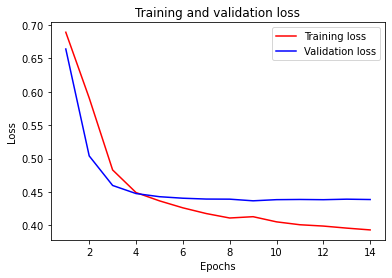

In [22]:
history_dict = model.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

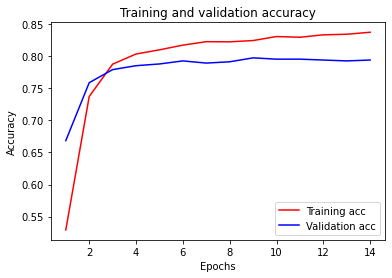

In [23]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [29]:
import tensorflow as tf

submission_dataset, submission_df = data_pipeline.prepare_submission_dataset(include_cols=["keyword", "location"], extract_extras=True, drop_limit=0)
submission_dataset = submission_dataset.batch(batch_size=64).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
submission_predictions = model.predict_for_kaggle(submission_dataset)

Getting the file: ../data/test.csv
Dataframe size before eliminating too short texts: 3263
Dataframe size after eliminating too short texts: 3263
         id keyword location  \
0         0                    
1         2                    
2         3                    
3         9                    
4        11                    
...     ...     ...      ...   
3258  10861                    
3259  10865                    
3260  10868                    
3261  10874                    
3262  10875                    

                                                   text  
0                    just happened a terrible car crash  
1     heard about earthquake is different cities sta...  
2     there is a forest fire at spot pond geese are ...  
3                 apocalypse lighting spokane wildfires  
4         typhoon soudelor kills 28 in china and taiwan  
...                                                 ...  
3258  earthquake safety los angeles safety fasteners...  
3259 

In [35]:
submission_predictions_df = pd.DataFrame(submission_predictions)
submission_predictions_df = pd.DataFrame({"id" : submission_df["id"], "target" : submission_predictions_df[0]})

In [36]:
submission_predictions_df

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,0


In [38]:
submission_predictions_df.to_csv('kaggle_predictions.csv', index=False)

In [ ]:
model.save_model()
